In [46]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [47]:
# read back the pricing data
prices = pd.read_csv('pharma.csv', index_col=['date'])
prices.head(10)

SUNPHARMA.NS   DRREDDY.NS  DIVISLAB.NS    CIPLA.NS    LUPIN.NS  \
date                                                                         
01-01-2018    574.049988  2404.149902  1099.050049  611.500000  883.250000   
02-01-2018    572.150024  2409.199951  1080.900024  607.799988  875.150024   
03-01-2018    569.049988  2339.000000  1099.400024  606.799988  878.950012   
04-01-2018    581.200012  2410.800049  1106.550049  616.750000  878.150024   
05-01-2018    578.750000  2473.399902  1107.650024  615.150024  900.150024   
08-01-2018    591.599976  2476.600098  1116.199951  615.049988  923.299988   
09-01-2018    586.500000  2457.800049  1089.300049  615.599976  923.250000   
10-01-2018    585.099976  2425.800049  1079.300049  619.750000  925.799988   
11-01-2018    587.950012  2425.350098  1101.550049  612.349976  929.200012   
12-01-2018    583.450012  2447.649902  1093.800049  612.099976  919.099976   

            LAURUSLABS.NS  AUROPHARMA.NS   BIOCON.NS     ALKEM.NS  
date                                                               
01-01-2018     107.919998     683.950012  269.000000  2225.949951  
02-01-2018     107.190002     671.400024  270.850006  2200.100098  
03-01-2018     107.370003     665.549988  270.924988  2213.050049  
04-01-2018     108.830002     668.299988  270.825012  2217.050049  
05-01-2018     110.290001     671.150024  270.475006  2220.300049  
08-01-2018     112.199997     677.349976  277.674988  2218.000000  
09-01-2018     110.699997     673.150024  272.750000  2222.100098  
10-01-2018     108.639999     672.700012  270.924988  2323.600098  
11-01-2018     110.050003     674.549988  273.125000  2287.250000  
12-01-2018     109.230003     667.049988  270.200012  2258.850098

In [48]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [49]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

SUNPHARMA.NS   DRREDDY.NS  DIVISLAB.NS    CIPLA.NS    LUPIN.NS  \
date                                                                         
01-01-2018    574.049988  2404.149902  1099.050049  611.500000  883.250000   
02-01-2018    572.150024  2409.199951  1080.900024  607.799988  875.150024   
30-12-2020    584.000000  5170.950195  3799.699951  823.799988  977.599976   
31-12-2020    592.349976  5205.100098  3841.899902  819.950012  976.849976   

            LAURUSLABS.NS  AUROPHARMA.NS   BIOCON.NS     ALKEM.NS  
date                                                               
01-01-2018     107.919998     683.950012  269.000000  2225.949951  
02-01-2018     107.190002     671.400024  270.850006  2200.100098  
30-12-2020     350.049988     906.750000  458.700012  2928.449951  
31-12-2020     353.149994     921.299988  465.399994  2926.199951

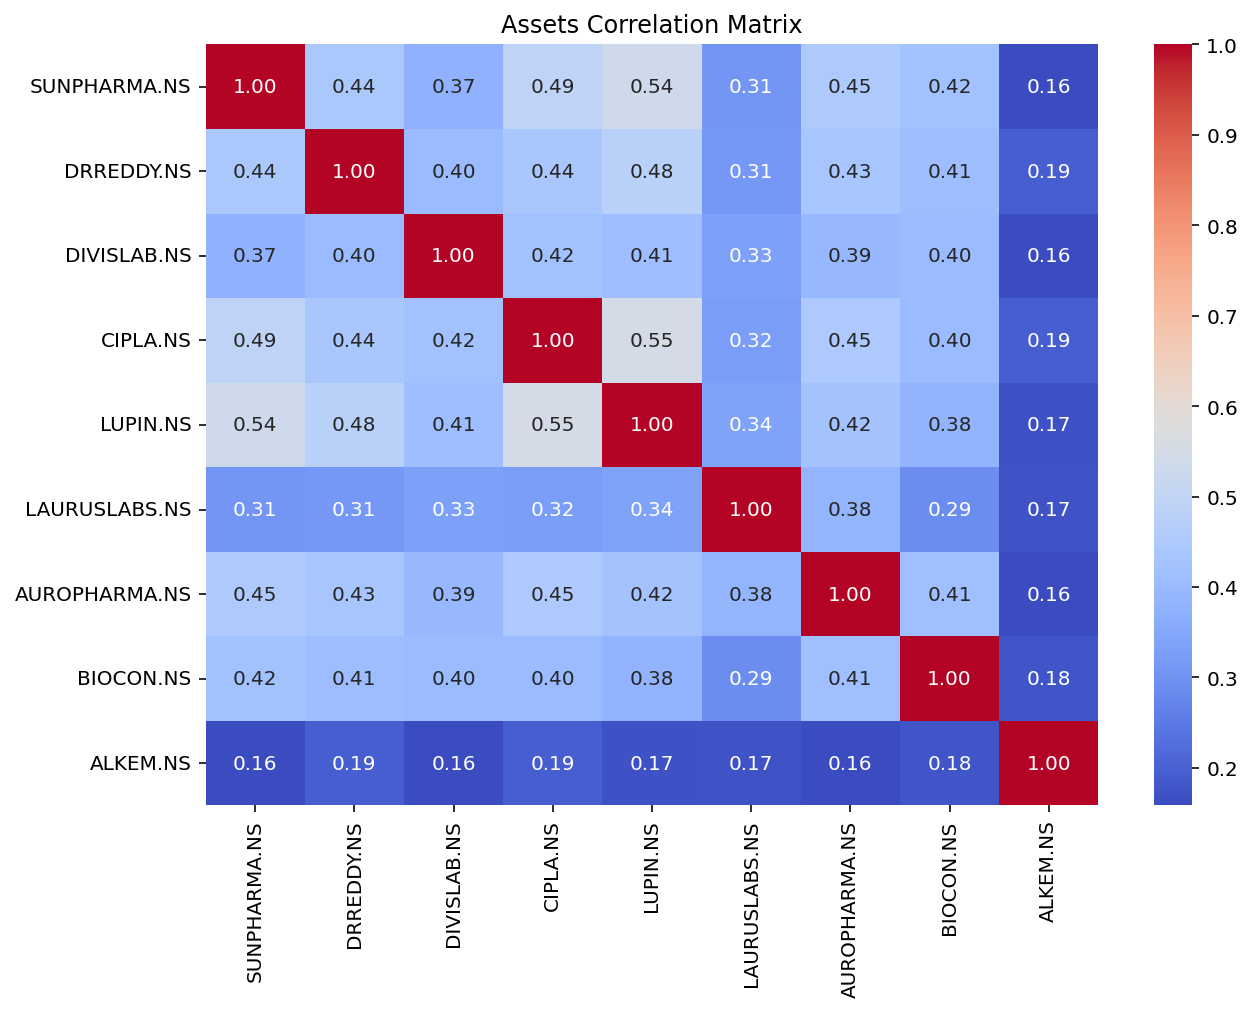

In [50]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [51]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('DRREDDY.NS', 'DIVISLAB.NS'), ('LUPIN.NS', 'BIOCON.NS')]


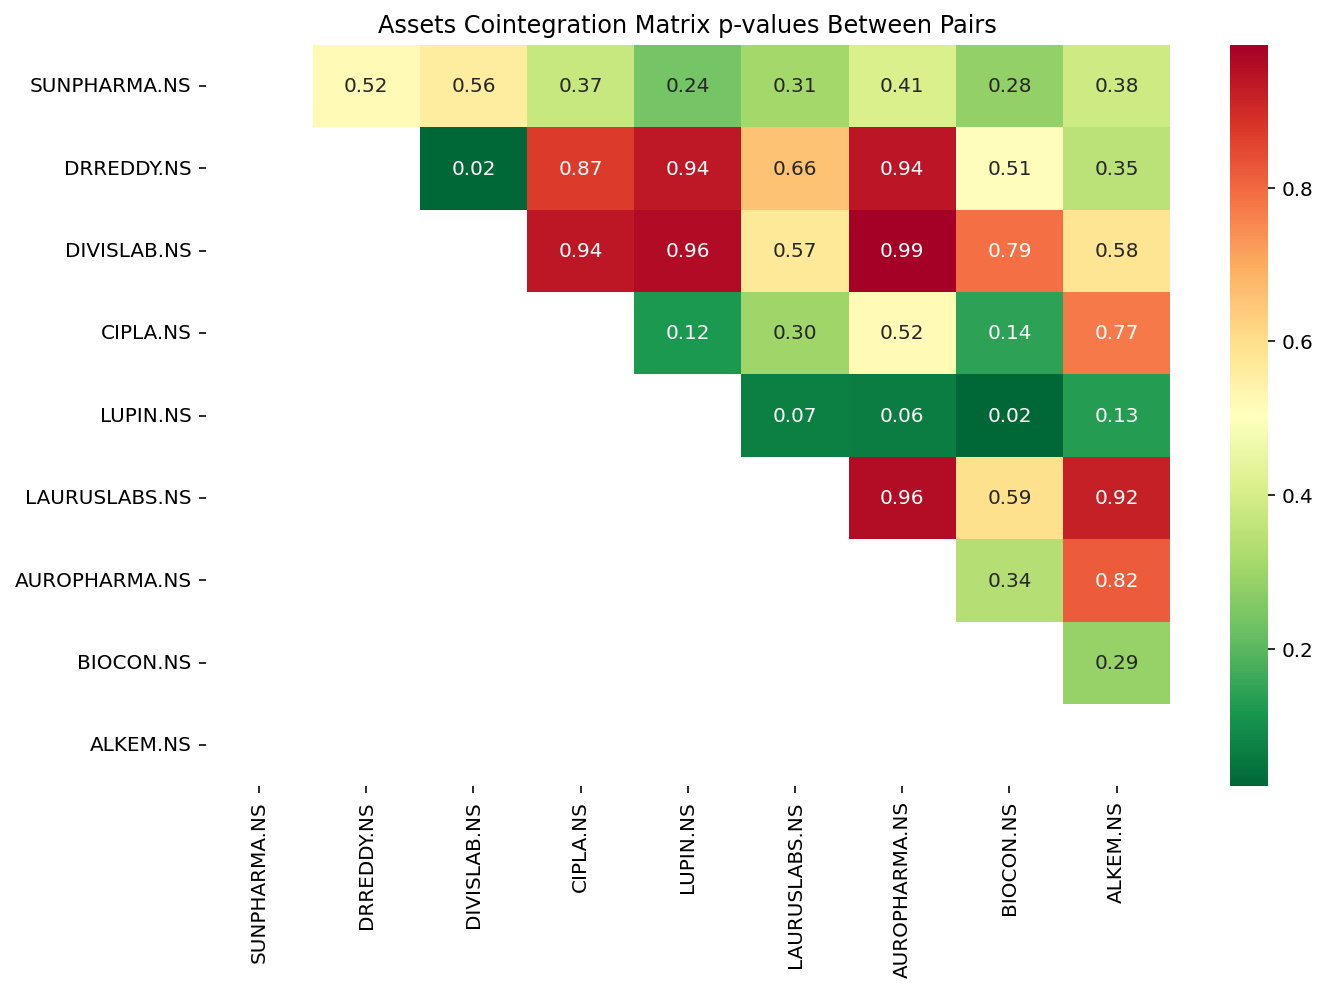

In [52]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [53]:
# final pair to test strategy
asset1 = 'LUPIN.NS'
asset2 = 'BIOCON.NS'

In [54]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

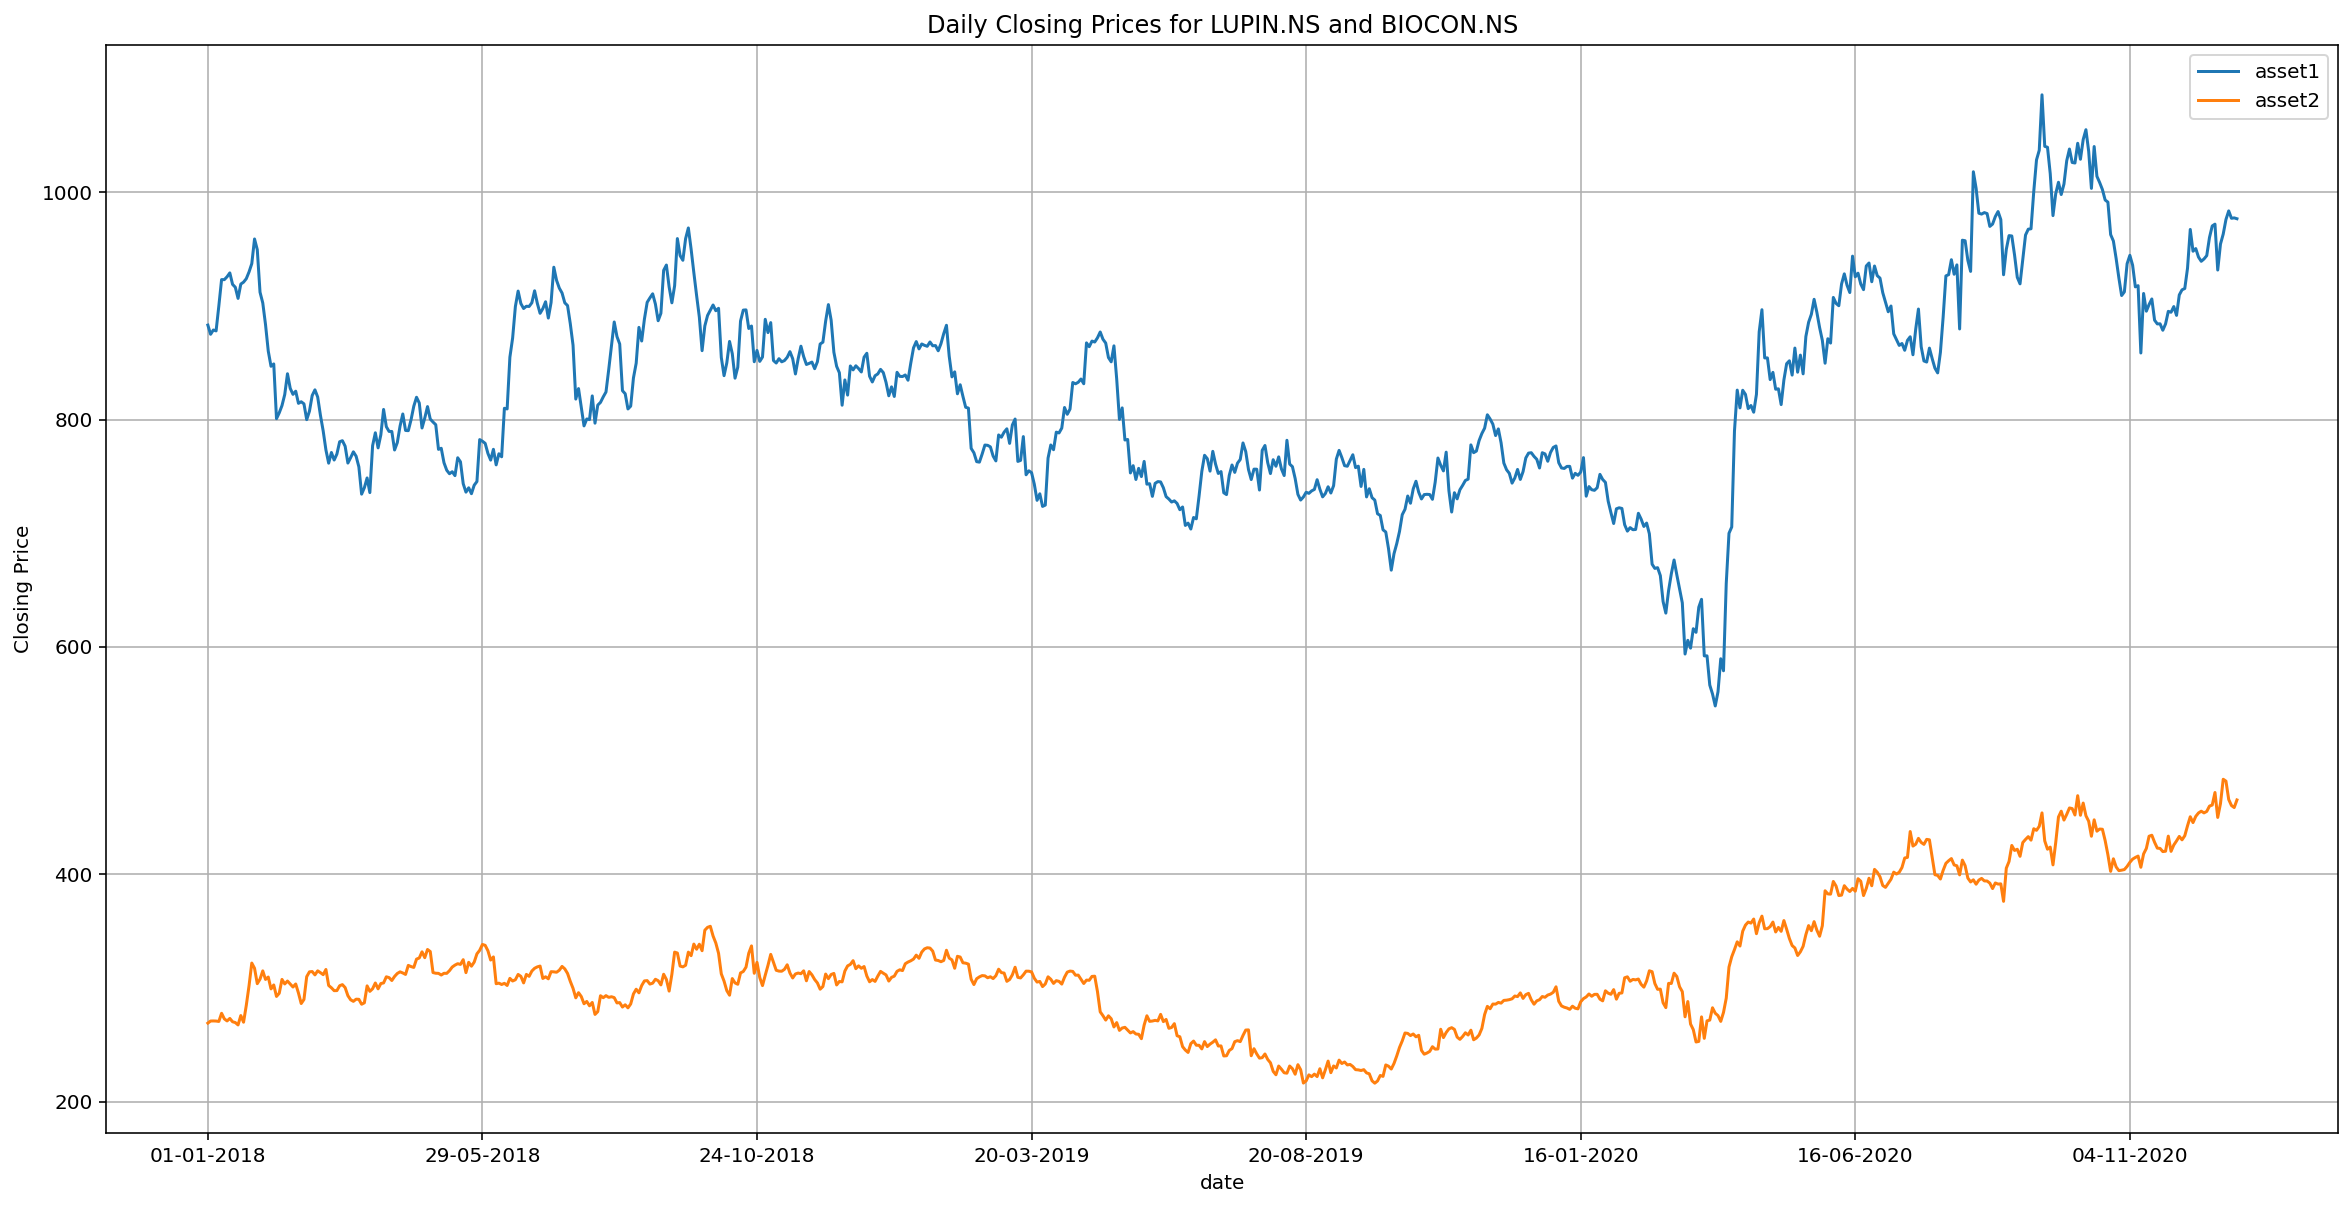

In [55]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [56]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [57]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                          4.561e+04
Date:                Sun, 20 Mar 2022   Prob (F-statistic):                        0.00
Time:                        23:13:40   Log-Likelihood:                         -3799.3
No. Observations:                 740   AIC:                                      7601.
Df Residuals:                     739   BIC:                                      7605.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.3881      0.002    213.558      0.000       0.385       0.392
==============================================================================
Omnibus:                       23.210   Durbin-Watson:                   0.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.774
Skew:                           0.329   Prob(JB):                     5.08e-05
Kurtosis:                       2.545   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

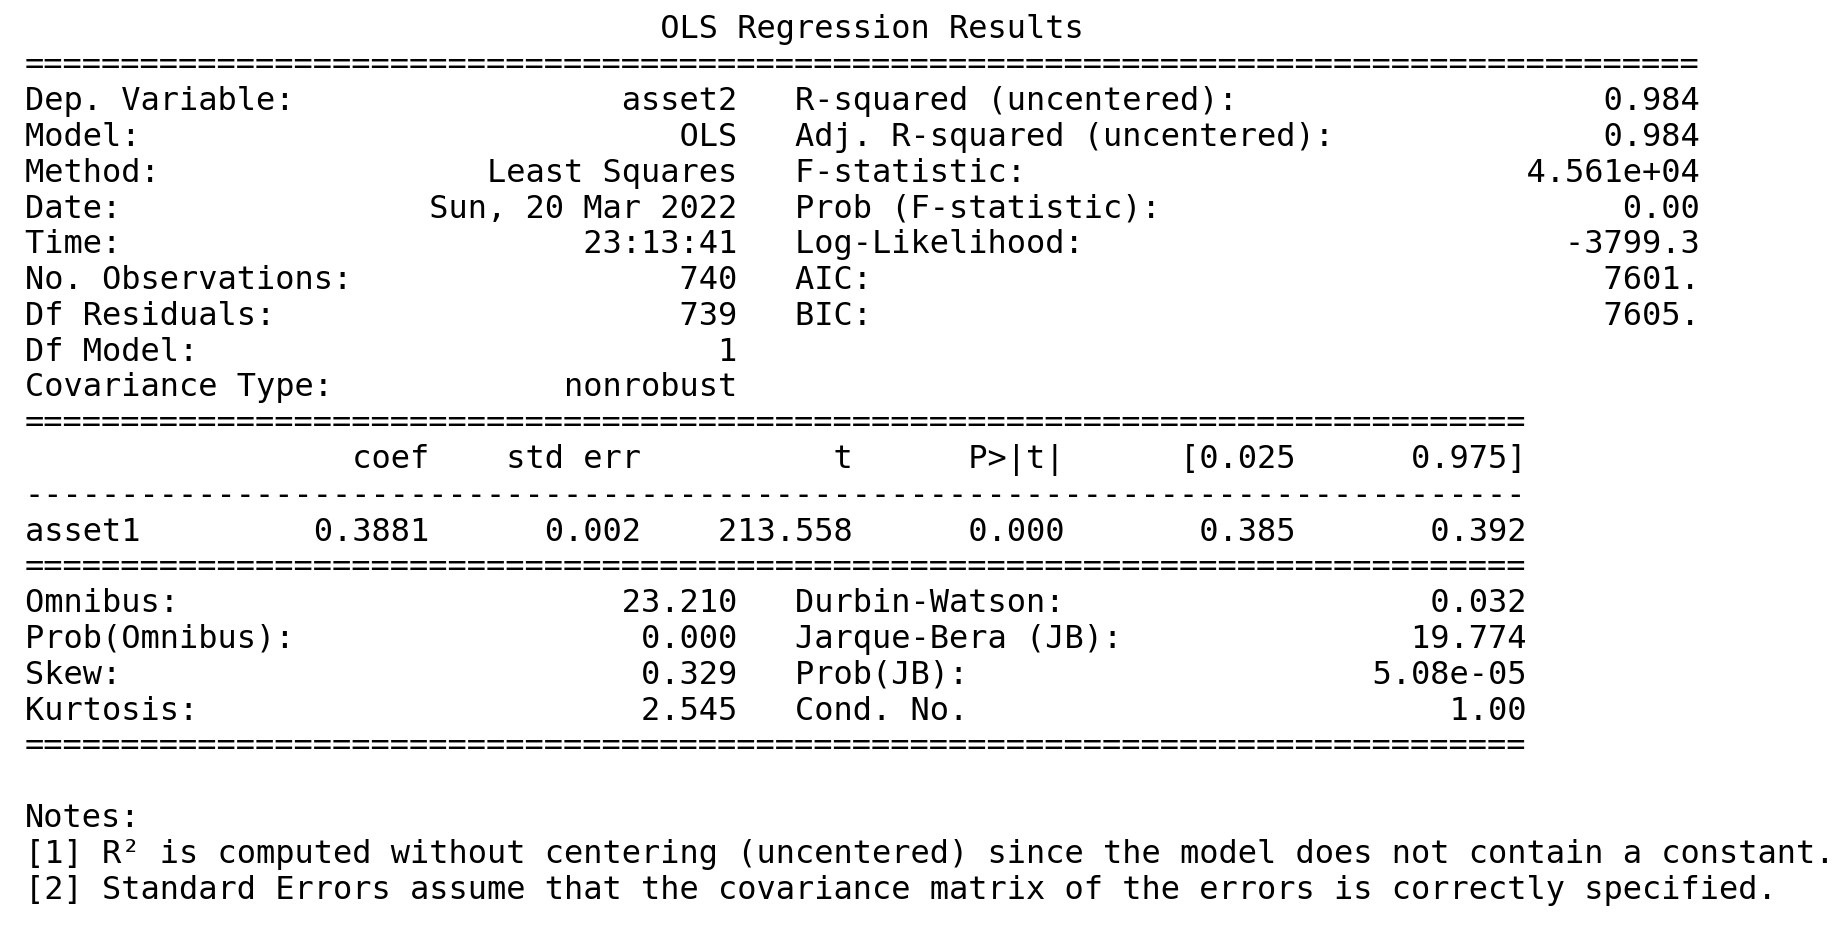

In [58]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [59]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.3880704863694964


In [60]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

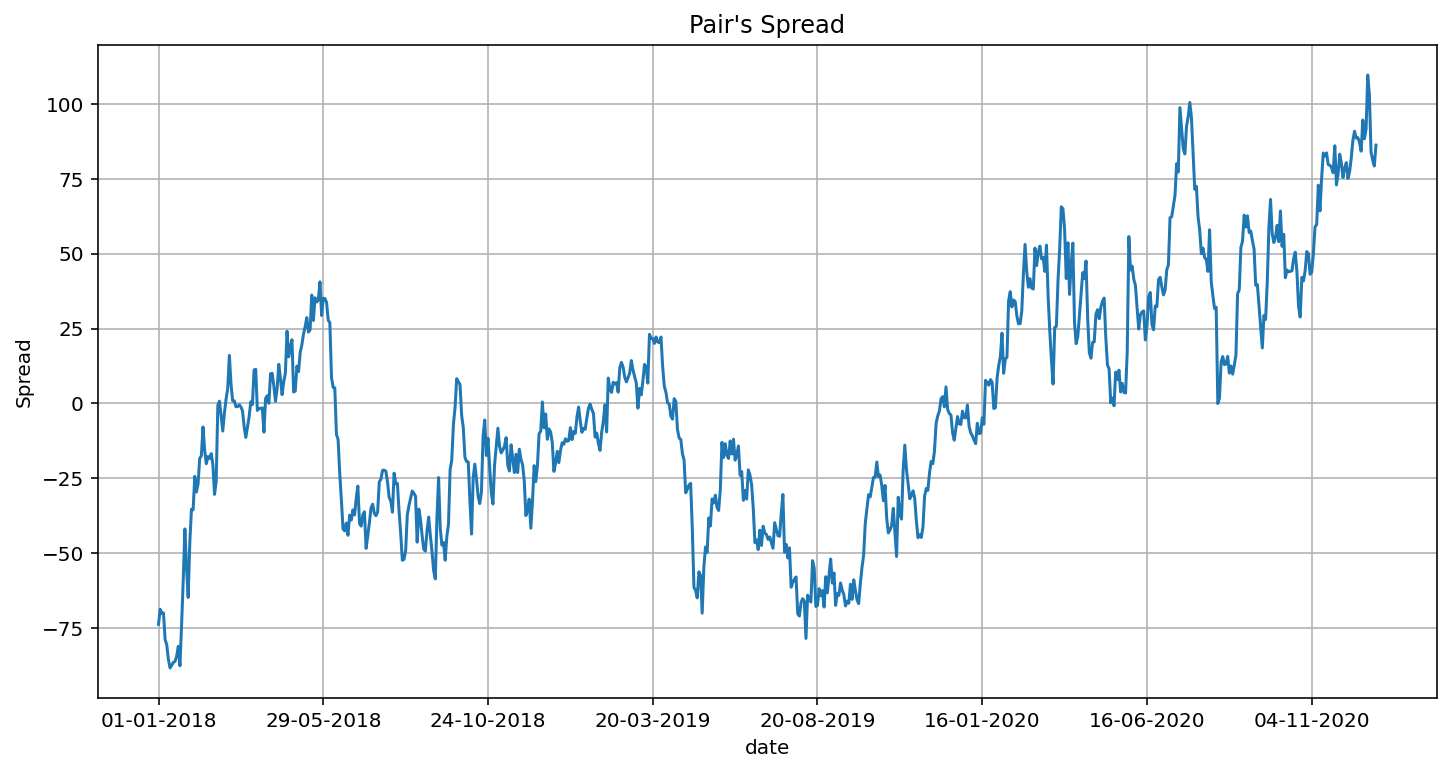

In [61]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [62]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-2.2917902382094995,
 0.17462945601521063,
 0,
 739,
 {'1%': -3.439229783394421,
  '5%': -2.86545894814762,
  '10%': -2.5688568756191392},
 5032.284635497262)

In [65]:
print('Critical Value = ', adf[0])

Critical Value =  -2.2917902382094995


In [66]:
# probablity critical values
print(adf[4])

{'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


### Generate Trading Signals using z-score

In [67]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [68]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [69]:
signals.head()

asset1      asset2
date                               
01-01-2021  1000.900024  465.750000
04-01-2021  1026.949951  467.000000
05-01-2021  1039.949951  467.649994
06-01-2021  1000.599976  459.750000
07-01-2021  1022.250000  454.799988

In [70]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [71]:
signals.head()

asset1      asset2         z  z upper limit  z lower limit
date                                                                       
01-01-2021  1000.900024  465.750000 -2.406446            1.0           -1.0
04-01-2021  1026.949951  467.000000 -2.187020            1.0           -1.0
05-01-2021  1039.949951  467.649994 -2.078502            1.0           -1.0
06-01-2021  1000.599976  459.750000 -2.286301            1.0           -1.0
07-01-2021  1022.250000  454.799988 -1.973621            1.0           -1.0

In [72]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [73]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

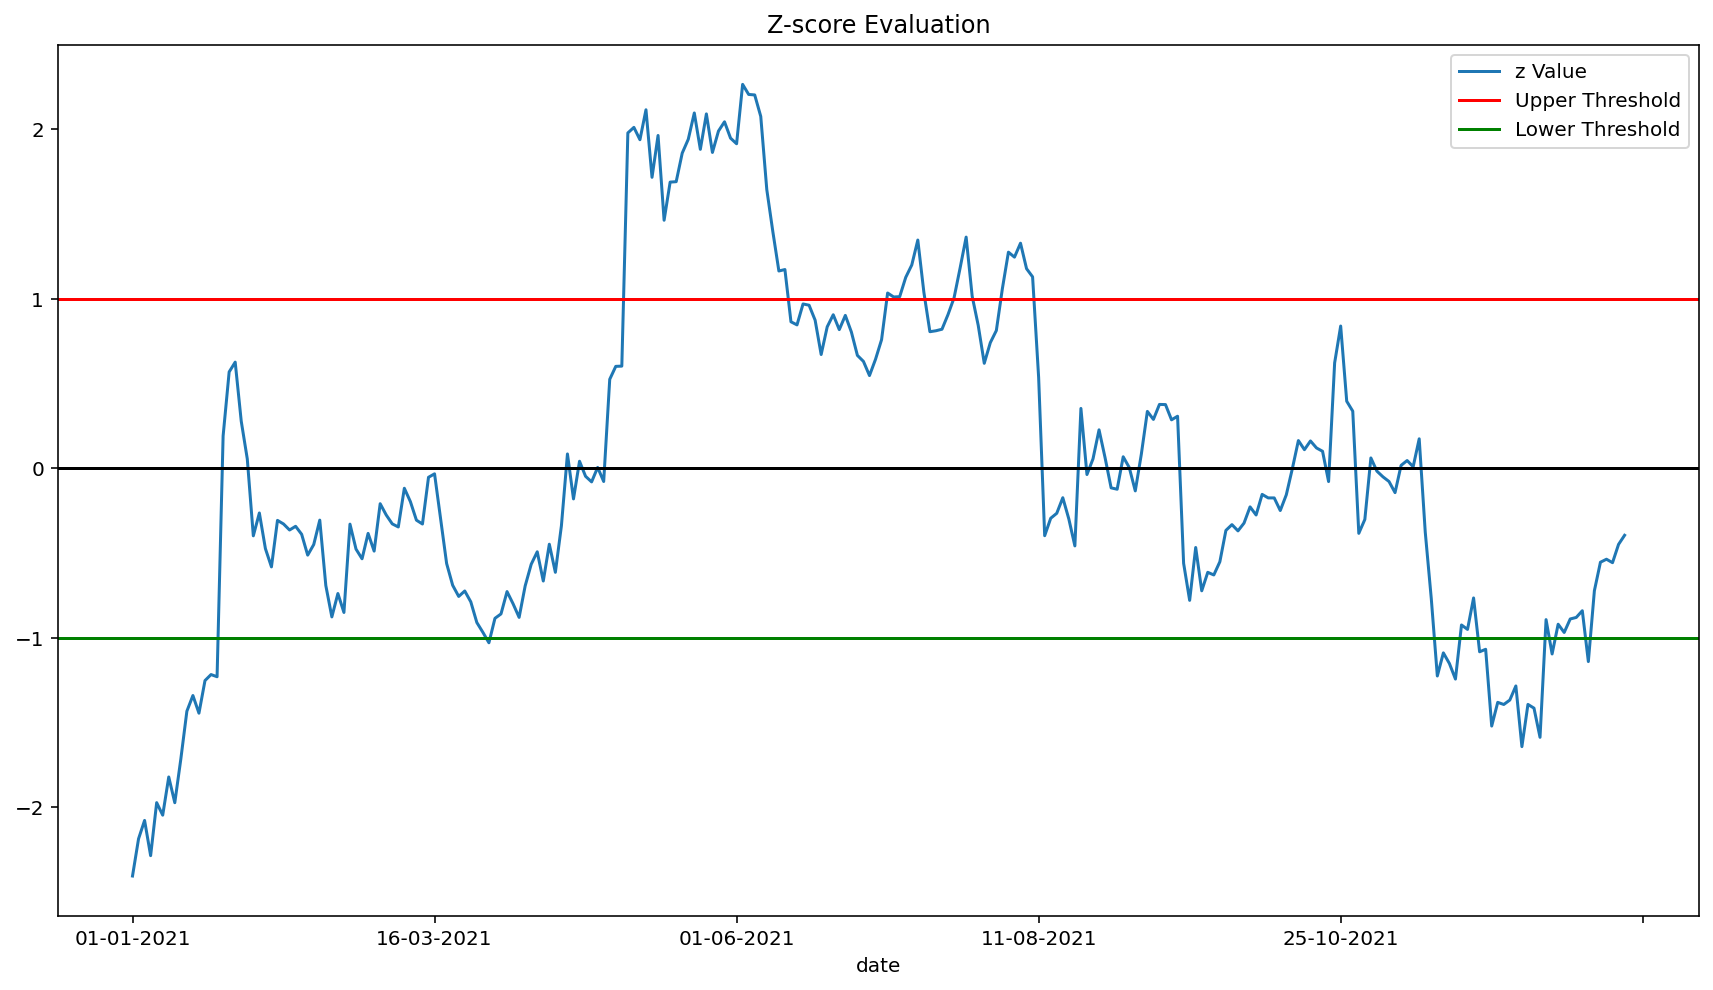

In [74]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [75]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  1000.900024  465.750000 -2.406446            1.0           -1.0   
04-01-2021  1026.949951  467.000000 -2.187020            1.0           -1.0   
05-01-2021  1039.949951  467.649994 -2.078502            1.0           -1.0   
29-12-2021   929.599976  361.649994 -0.558055            1.0           -1.0   
30-12-2021   937.849976  361.399994 -0.450134            1.0           -1.0   
31-12-2021   950.750000  364.649994 -0.396416            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0

In [76]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  1000.900024  465.750000 -2.406446            1.0           -1.0   
04-01-2021  1026.949951  467.000000 -2.187020            1.0           -1.0   
05-01-2021  1039.949951  467.649994 -2.078502            1.0           -1.0   
06-01-2021  1000.599976  459.750000 -2.286301            1.0           -1.0   
07-01-2021  1022.250000  454.799988 -1.973621            1.0           -1.0   
08-01-2021  1038.800049  465.649994 -2.047441            1.0           -1.0   
11-01-2021  1075.500000  471.250000 -1.822144            1.0           -1.0   
12-01-2021  1060.300049  471.750000 -1.974070            1.0           -1.0   
13-01-2021  1067.400024  462.799988 -1.716145            1.0           -1.0   
14-01-2021  1105.800049  466.450012 -1.434232            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
06-01-2021         1         0.0        -1         0.0  
07-01-2021         1         0.0        -1         0.0  
08-01-2021         1         0.0        -1         0.0  
11-01-2021         1         0.0        -1         0.0  
12-01-2021         1         0.0        -1         0.0  
13-01-2021         1         0.0        -1         0.0  
14-01-2021         1         0.0        -1         0.0

In [77]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  1000.900024  465.750000 -2.406446            1.0           -1.0   
22-01-2021  1079.250000  393.750000  0.189801            1.0           -1.0   
30-03-2021  1005.900024  408.450012 -1.030493            1.0           -1.0   
31-03-2021  1020.450012  408.899994 -0.886313            1.0           -1.0   
05-05-2021  1200.500000  381.299988  1.977022            1.0           -1.0   
14-12-2021   943.049988  378.149994 -0.893972            1.0           -1.0   
15-12-2021   918.849976  375.399994 -1.096585            1.0           -1.0   
16-12-2021   903.400024  363.149994 -0.921053            1.0           -1.0   
23-12-2021   912.450012  374.350006 -1.141458            1.0           -1.0   
24-12-2021   897.750000  354.450012 -0.723159            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
22-01-2021         0        -1.0         0         1.0  
30-03-2021         1         1.0        -1        -1.0  
31-03-2021         0        -1.0         0         1.0  
05-05-2021        -1        -1.0         1         1.0  
14-12-2021         0        -1.0         0         1.0  
15-12-2021         1         1.0        -1        -1.0  
16-12-2021         0        -1.0         0         1.0  
23-12-2021         1         1.0        -1        -1.0  
24-12-2021         0        -1.0         0         1.0

In [78]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

1005.900024    1
1192.650024    1
1161.800049    1
1102.949951    1
1050.750000    1
910.150024     1
893.000000     1
918.849976     1
912.450012     1
Name: asset1, dtype: int64

In [79]:
signals

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  1000.900024  465.750000 -2.406446            1.0           -1.0   
04-01-2021  1026.949951  467.000000 -2.187020            1.0           -1.0   
05-01-2021  1039.949951  467.649994 -2.078502            1.0           -1.0   
06-01-2021  1000.599976  459.750000 -2.286301            1.0           -1.0   
07-01-2021  1022.250000  454.799988 -1.973621            1.0           -1.0   
...                 ...         ...       ...            ...            ...   
27-12-2021   916.450012  356.450012 -0.555394            1.0           -1.0   
28-12-2021   916.599976  355.950012 -0.537706            1.0           -1.0   
29-12-2021   929.599976  361.649994 -0.558055            1.0           -1.0   
30-12-2021   937.849976  361.399994 -0.450134            1.0           -1.0   
31-12-2021   950.750000  364.649994 -0.396416            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
06-01-2021         1         0.0        -1         0.0  
07-01-2021         1         0.0        -1         0.0  
...              ...         ...       ...         ...  
27-12-2021         0         0.0         0         0.0  
28-12-2021         0         0.0         0         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0  

[248 rows x 9 columns]

In [80]:
signals = signals.reset_index()

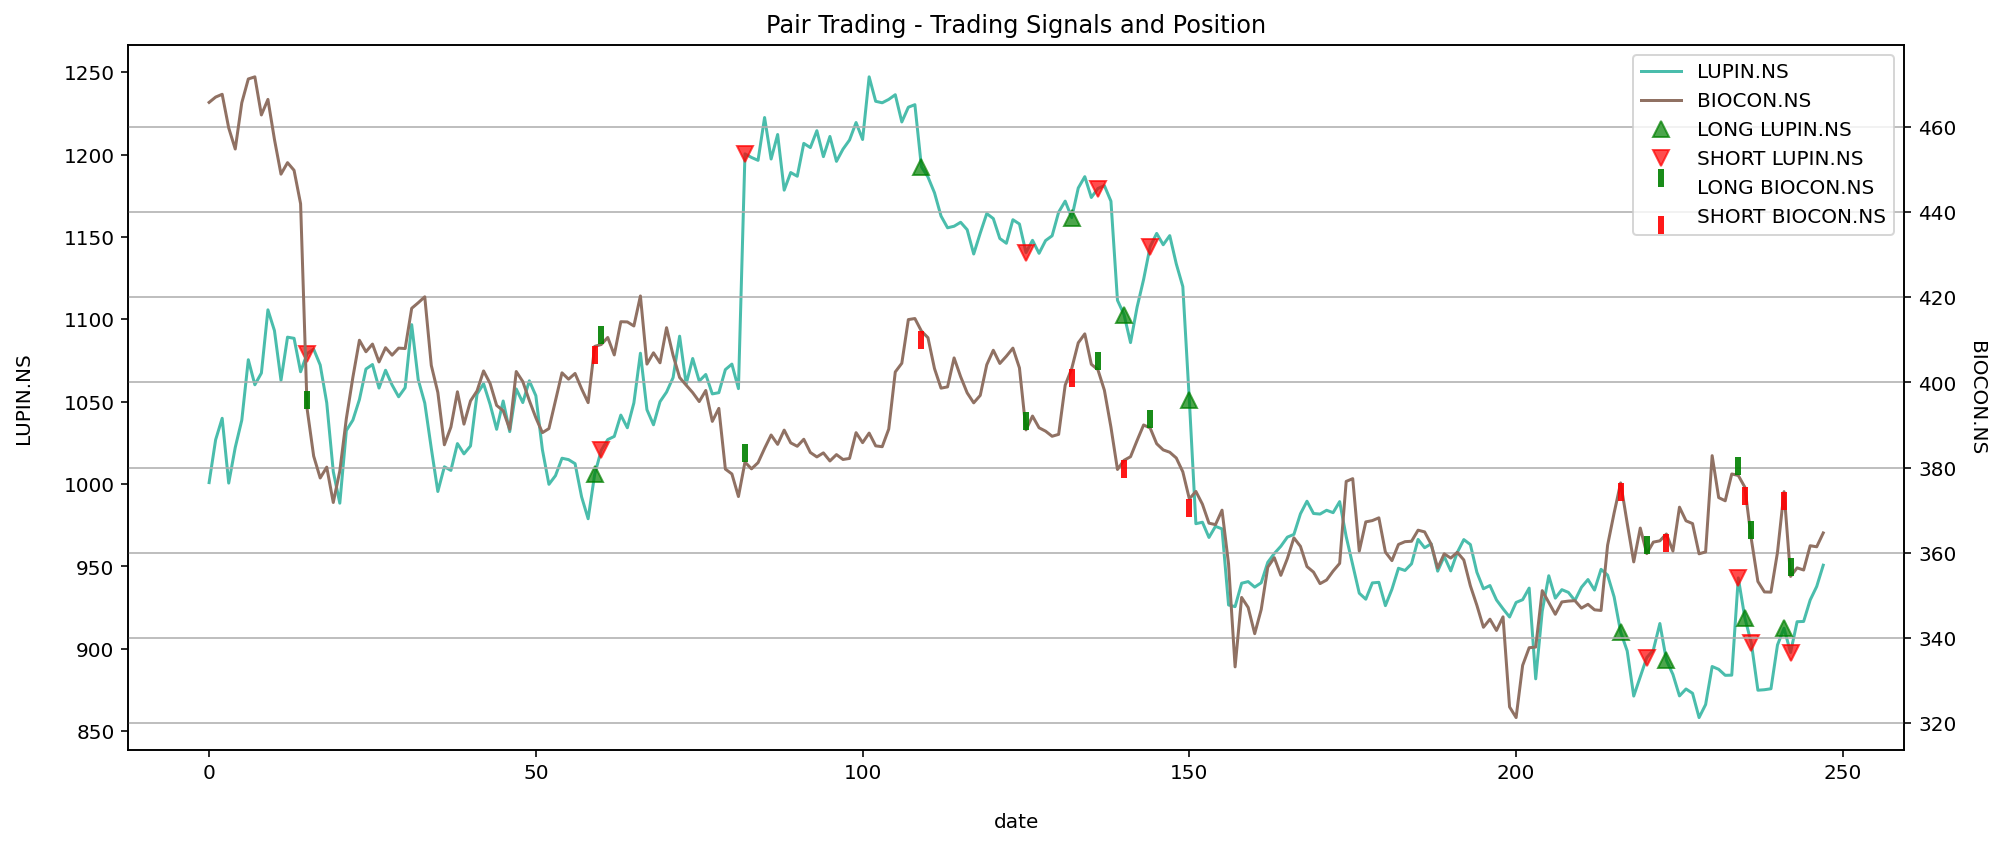

In [81]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [82]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [83]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [84]:
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    1000.900024           NaN            NaN            NaN       NaN   
1    1026.949951      0.000000  100000.000000  100000.000000       NaN   
2    1039.949951      0.000000  100000.000000  100000.000000  0.000000   
3    1000.599976      0.000000  100000.000000  100000.000000  0.000000   
4    1022.250000      0.000000  100000.000000  100000.000000  0.000000   
243   916.450012 -73316.000976  200383.994176  127067.993200 -0.011636   
244   916.599976 -73327.998048  200383.994176  127055.996128 -0.000094   
245   929.599976 -74367.998048  200383.994176  126015.996128 -0.008185   
246   937.849976 -75027.998048  200383.994176  125355.996128 -0.005237   
247   950.750000 -76060.000000  200383.994176  124323.994176 -0.008233   

     positions1  
0           NaN  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [85]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1         cash1  total asset1   return1  \
0   1000.900024           NaN           NaN           NaN       NaN   
15  1079.250000  -86340.00000  186340.00000  100000.00000  0.000000   
59  1005.900024       0.00000  105867.99808  105867.99808 -0.019959   
60  1020.450012  -81636.00096  187503.99904  105867.99808  0.000000   
82  1200.500000 -192080.00000  283543.99904   91463.99904 -0.110861   

    positions1  
0          NaN  
15        -1.0  
59         1.0  
60        -1.0  
82        -1.0

In [86]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [87]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    1000.900024           NaN            NaN            NaN       NaN   
1    1026.949951      0.000000  100000.000000  100000.000000       NaN   
2    1039.949951      0.000000  100000.000000  100000.000000  0.000000   
3    1000.599976      0.000000  100000.000000  100000.000000  0.000000   
4    1022.250000      0.000000  100000.000000  100000.000000  0.000000   
243   916.450012 -73316.000976  200383.994176  127067.993200 -0.011636   
244   916.599976 -73327.998048  200383.994176  127055.996128 -0.000094   
245   929.599976 -74367.998048  200383.994176  126015.996128 -0.008185   
246   937.849976 -75027.998048  200383.994176  125355.996128 -0.005237   
247   950.750000 -76060.000000  200383.994176  124323.994176 -0.008233   

     positions1      asset2     holdings2          cash2   total asset2  \
0           NaN  465.750000           NaN            NaN            NaN   
1           0.0  467.000000      0.000000  100000.000000  100000.000000   
2           0.0  467.649994      0.000000  100000.000000  100000.000000   
3           0.0  459.750000      0.000000  100000.000000  100000.000000   
4           0.0  454.799988      0.000000  100000.000000  100000.000000   
243         0.0  356.450012  75210.952574   25728.006435  100938.959010   
244         0.0  355.950012  75105.452574   25728.006435  100833.459010   
245         0.0  361.649994  76308.148713   25728.006435  102036.155148   
246         0.0  361.399994  76255.398713   25728.006435  101983.405148   
247         0.0  364.649994  76941.148713   25728.006435  102669.155148   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000         0.0  
3    0.000000         0.0  
4    0.000000         0.0  
243  0.004198         0.0  
244 -0.001045         0.0  
245  0.011928         0.0  
246 -0.000517         0.0  
247  0.006724         0.0

In [88]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1         cash1  total asset1   return1  \
0   1000.900024           NaN           NaN           NaN       NaN   
15  1079.250000  -86340.00000  186340.00000  100000.00000  0.000000   
59  1005.900024       0.00000  105867.99808  105867.99808 -0.019959   
60  1020.450012  -81636.00096  187503.99904  105867.99808  0.000000   
82  1200.500000 -192080.00000  283543.99904   91463.99904 -0.110861   

    positions1      asset2      holdings2          cash2   total asset2  \
0          NaN  465.750000            NaN            NaN            NaN   
15        -1.0  393.750000   83081.250000   16918.750000  100000.000000   
59         1.0  408.450012       0.000000  103101.702574  103101.702574   
60        -1.0  408.899994   86277.898713   16823.803861  103101.702574   
82        -1.0  381.299988  160908.594852  -63630.493565   97278.101287   

     return2  positions2  
0        NaN         NaN  
15  0.000000         1.0  
59  0.027764        -1.0  
60  0.000000         1.0  
82  0.017883         1.0

In [89]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

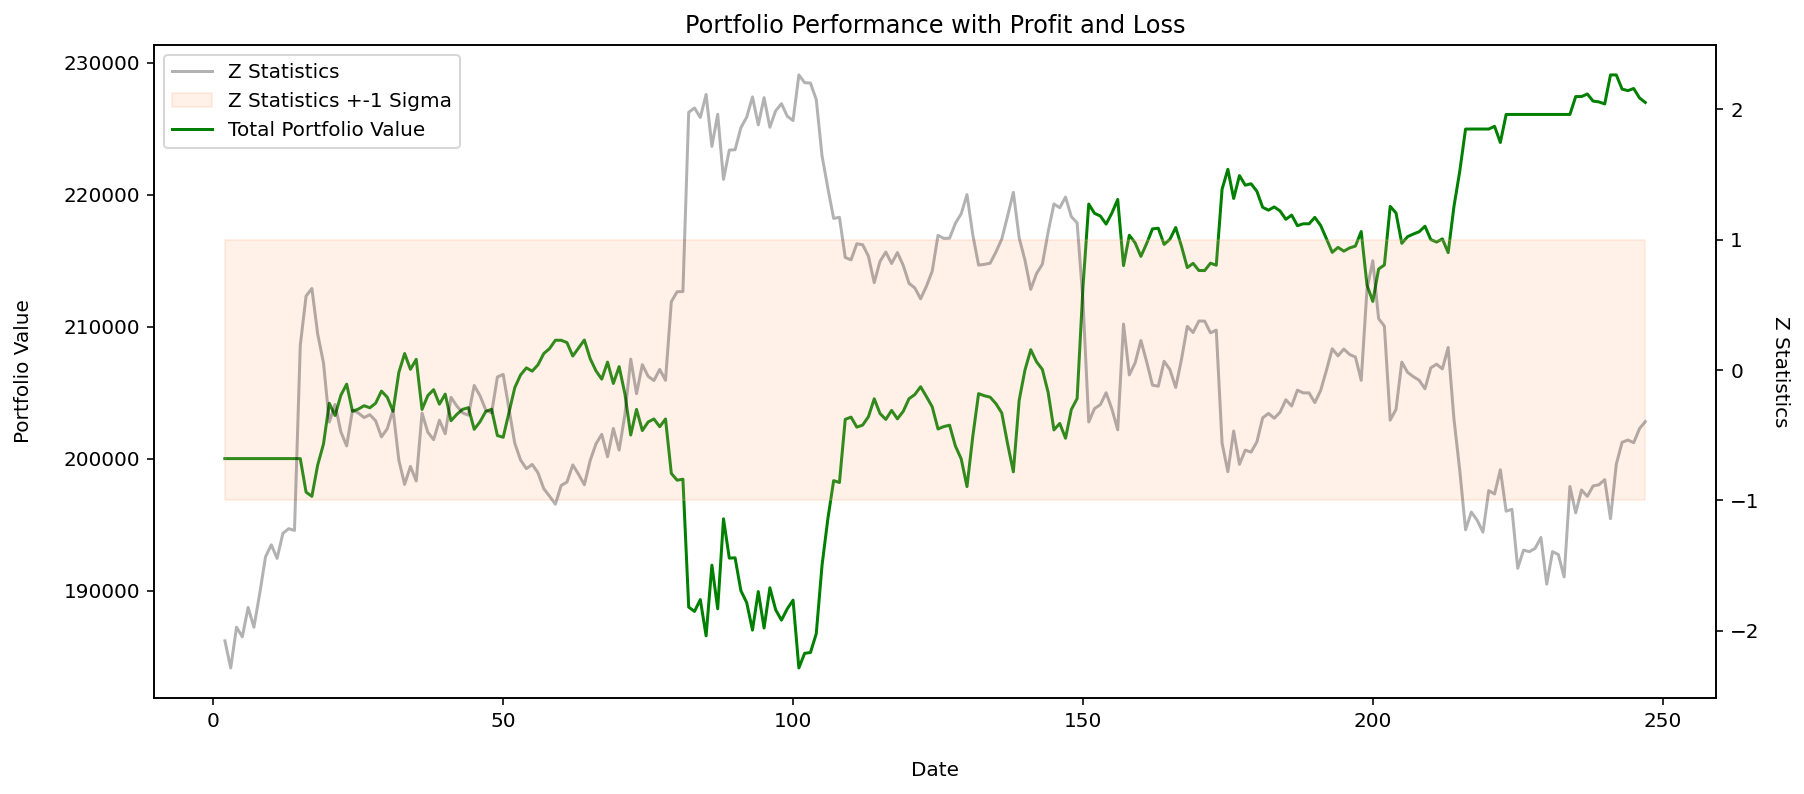

In [90]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [91]:
#portfolio = pd.read_csv('portfolio.csv')

In [92]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

226993.1493244

In [93]:
profit = final_portfolio - 2*initial_capital
profit

26993.1493244

In [94]:
roi = (profit / (2*initial_capital))*100
roi

13.4965746622

In [ ]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

In [46]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 239.146%
